# Exploratory Data Science

In this notebook, we'll take an opportunity to explore the use case, data and models we'll be using.
Data exploration and understanding the task at hand is a fundamental step in Machine Learning.

Our task is to use object detection model to identify dogs in static photogaphs. 

In this notebook we explore this task and data and use a pre-trained object detection model.

The aim of this notebook is to ensure we have a model which we can use to identify if a dog is present in a static image. This notebook closely follows the tutorial and code provided by the TensorFlow Hub team [here](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

In [4]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont


import matplotlib.pyplot as plt

print(f'Tensorflow Version {tf.__version__}')

Tensorflow Version 2.5.0


## Connect to data in s3

In [9]:
import os
import boto3
from boto3 import session
import os
key_id = os.environ.get('AWS_ACCESS_KEY_ID')
print(key_id)
secret_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

None


In [4]:
s3_client = boto3.client('s3', aws_access_key_id=key_id, aws_secret_access_key=secret_key)
bucket_name = 'dog-detector'
s3_client.download_file('dog-detector', 'twodogs.jpg', 'twodogs.jpg')


## Import our image

In the next few cells we import the image we want to test our model on. We'll be using a pre-trained TensorFlow model, so I'm going to use tensorflow to import our image. 

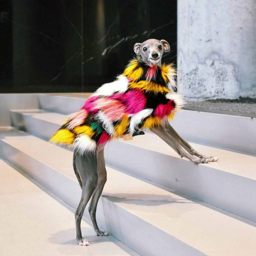

In [10]:
# dog_img = 'twodogs.jpg'
dog_img = 'biba.jpg'
dogs = Image.open(dog_img)
dogs.resize((256,256))

This image shows 2 dogs, Max and Margot. We need to import the image using as a Tensor so the TensorFlow model we will use can process the image.

In [11]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [12]:
tf_dogs = load_img(dog_img)
tf_dogs 

<tf.Tensor: shape=(700, 700, 3), dtype=uint8, numpy=
array([[[ 13,  14,   8],
        [ 13,  14,   8],
        [ 13,  14,   8],
        ...,
        [153, 151, 156],
        [155, 153, 158],
        [156, 154, 159]],

       [[ 11,  12,   6],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [150, 148, 153],
        [151, 149, 154],
        [152, 150, 155]],

       [[  9,  10,   4],
        [  9,  10,   4],
        [  9,  10,   4],
        ...,
        [151, 149, 154],
        [150, 148, 153],
        [149, 147, 152]],

       ...,

       [[232, 213, 199],
        [232, 213, 199],
        [233, 214, 200],
        ...,
        [236, 217, 203],
        [236, 217, 203],
        [236, 217, 203]],

       [[232, 213, 199],
        [232, 213, 199],
        [233, 214, 200],
        ...,
        [236, 217, 203],
        [236, 217, 203],
        [236, 217, 203]],

       [[232, 213, 199],
        [232, 213, 199],
        [233, 214, 200],
        ...,
        [236, 217, 20

## Load in a model 

The model we are going to use today is the ssd Mobilenet v2/1 model, which you can download from TensorFlow Hub [here](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1). The model has been trained on Google's [Open Images](https://storage.googleapis.com/openimages/web/index.html) v4 data set, and can recognise 600 types of objects. We begin by loading in the model. 

In [13]:
model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
detector = saved_model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Our model expects tensors to be passed as floats, so we transform the image appropriately:

In [14]:
converted_img  = tf.image.convert_image_dtype(tf_dogs, tf.float32)[tf.newaxis, ...]

In [15]:
result = detector(converted_img)
result

{'detection_class_labels': <tf.Tensor: shape=(100,), dtype=int64, numpy=
 array([446, 434, 434, 456, 456, 434, 434, 122, 434, 434, 456, 434, 456,
        456, 456, 456, 456, 456, 456, 434, 456, 456, 434, 434, 456, 485,
        456, 456, 456, 456, 502, 456, 456, 434, 434, 434, 434, 446, 456,
        456, 456, 456, 456, 456, 456, 456, 456, 456, 434, 456, 434, 456,
        434, 221, 434, 456, 456,  69, 391, 391, 456, 434, 456, 456, 456,
        456, 434, 434, 391, 391, 485, 456, 434, 456, 456, 434, 456, 434,
        433, 391, 456, 456, 391, 434, 434, 434, 434, 485, 456, 456, 434,
        434,  97, 334, 456, 456, 434, 391, 456, 456])>,
 'detection_scores': <tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([0.7968451 , 0.14286971, 0.14032215, 0.12260401, 0.11879799,
        0.11620024, 0.11597386, 0.1127781 , 0.11045992, 0.10032934,
        0.09922302, 0.0992001 , 0.09797373, 0.09542063, 0.09458047,
        0.09396717, 0.09396401, 0.09383759, 0.09156689, 0.0904946 ,
        0.09025905,

In [16]:
def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.grid(False)
  plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
    
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [17]:
result = {key:value.numpy() for key,value in result.items()}

image_with_boxes = draw_boxes(
      tf_dogs.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

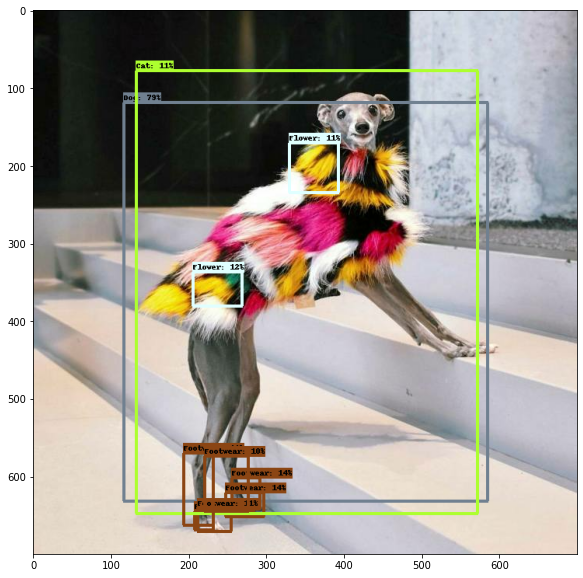

In [18]:
display_image(image_with_boxes)

so, you can see we've got some predictions for 'dog' and also some for 'footwear', and we can now see what parts of the image have been identified as such. 

However, if we look at the detection scores, some of the predictions are not made with high confidence: 

In [19]:
result['detection_scores']

array([0.7968451 , 0.14286971, 0.14032215, 0.12260401, 0.11879799,
       0.11620024, 0.11597386, 0.1127781 , 0.11045992, 0.10032934,
       0.09922302, 0.0992001 , 0.09797373, 0.09542063, 0.09458047,
       0.09396717, 0.09396401, 0.09383759, 0.09156689, 0.0904946 ,
       0.09025905, 0.08896601, 0.08881328, 0.08880466, 0.08689079,
       0.08540529, 0.08540317, 0.08537522, 0.08480486, 0.0837228 ,
       0.08064601, 0.08016831, 0.07764575, 0.07691607, 0.07676554,
       0.0766719 , 0.07528982, 0.07469645, 0.07468298, 0.07413894,
       0.0723775 , 0.07227755, 0.07191908, 0.07171646, 0.07047838,
       0.0703564 , 0.07024032, 0.07020748, 0.07019445, 0.07018659,
       0.06959957, 0.06820115, 0.06790665, 0.06723633, 0.06716591,
       0.0671559 , 0.0668689 , 0.06677669, 0.06664574, 0.06598943,
       0.06591925, 0.06554624, 0.06520629, 0.06495667, 0.06433499,
       0.06353578, 0.06350905, 0.06331557, 0.06328082, 0.06323808,
       0.06273311, 0.06273225, 0.06258798, 0.06235892, 0.06193

Let's only draw boxes if the model classified them as more than 50% likely

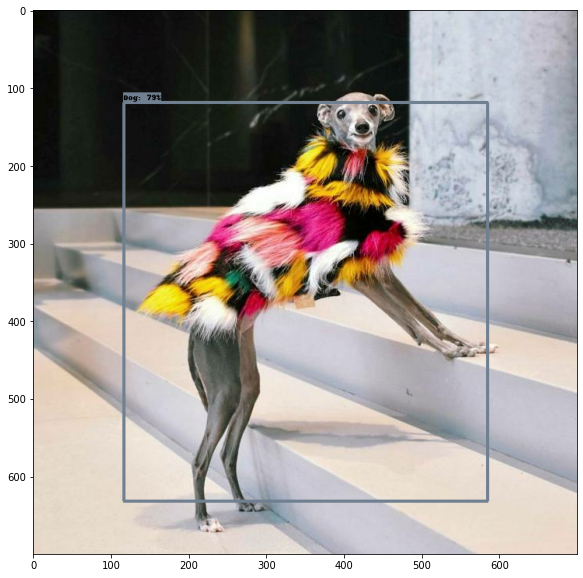

In [20]:
per=0.5
image_with_boxes_per = draw_boxes(
      tf_dogs.numpy(), result["detection_boxes"][result["detection_scores"]>per],
      result["detection_class_entities"][result["detection_scores"]>per], 
    result["detection_scores"][result["detection_scores"]>per])

display_image(image_with_boxes_per)
    